In [1]:
import pandas as pd
import os
import numpy as np
import logging
import sys
import torch
import copy
import yaml
import random

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from skmisc.loess import loess
from sklearn.metrics import log_loss, brier_score_loss

from prediction_utils.pytorch_utils.metrics import (
    StandardEvaluator,
    FairOVAEvaluator,
    CalibrationEvaluator
)

#from sklearn import metrics
import statsmodels.api as sm

sns.set_style("ticks")
custom_palette = ["red", "green", "orange", "blue"]
sns.set_palette(custom_palette)
grp_label_dict = {1: 'Black women', 2: 'White women', 3: 'Black men', 4: 'White men'}    

#EXPERIMENT_NAME = 'big_test_mmd_tuning'
#EXPERIMENT_NAME = 'big_test_erm_recalibration'
EXPERIMENT_NAME = 'big_test_regularized_tuning'
#EXPERIMENT_NAME = 'big_test_erm_tuning'

num_configs=9

args = {'experiment_name': EXPERIMENT_NAME,
        'cohort_path': '/labs/shahlab/projects/agataf/data/pooled_cohorts/cohort_extraction/all_cohorts_0.2test.csv',
        'base_path': '/labs/shahlab/projects/agataf/data/cohorts/pooled_cohorts'
       }

output_path = '/labs/shahlab/projects/agataf/fairness_utility/eval/plots'
experiment_plot_path=os.path.join(output_path, EXPERIMENT_NAME)
aggregate_path = os.path.join(args['base_path'], 'experiments', 
                              EXPERIMENT_NAME, 'performance',
                              'all')

os.makedirs(experiment_plot_path, exist_ok=True)
os.makedirs(aggregate_path, exist_ok=True)

preds = pd.read_csv(os.path.join(aggregate_path, 'predictions.csv'))
preds_eval = preds.query("phase=='eval'")
preds_test = preds.query("phase=='test'")

### get results

In [2]:
def plot(df, zoom=False, output_path=None):
    g = sns.relplot(data = df,
                    x = 'pred_probs',
                    y = 'calibration_density',
                    row = 'is_white',
                    col = 'is_male',
                    kind = 'line',
                    hue = 'lambda_reg',
                    facet_kws = {'sharey': True, 'sharex': True},# 'margin_titles': True},
                    legend = True,
                    ci='sd',
                    aspect = 1.2)
    axes = g.axes.flatten()

    grp_label_dict = {1: 'Black women', 2: 'White women', 3: 'Black men', 4: 'White men'}    

    for i, ax in enumerate(axes):
        ax.axline(xy1 = (0,0), slope = 1, color = "b", dashes = (5, 2), label = "Perfectly calibrated")
        ax.axvline(x = 0.075, linestyle = '--', color = 'grey')
        ax.axvline(x = 0.2,   linestyle = '--', color = 'grey')
        ax.axhline(y = 0.075, linestyle = '--', color = 'grey')
        ax.axhline(y = 0.2,   linestyle = '--', color = 'grey')
        ax.set_title(grp_label_dict[i+1])
        if zoom:
            ax.set(xlim = (0, 0.25), ylim = (0, 0.25))
        else:
            ax.set(xlim = (0, 1), ylim = (0, 1))
        if i > 1:
            ax.set_xlabel("predicted risk")
        if ((i % 2) == 0):
            ax.set_ylabel("fraction of positives")
    if output_path is not None:
        g.savefig(output_path)

## use calibration evaluator, aggregate across folds

In [3]:
def calib_performance(model, x, y, sample_weight=None, transform=None):
    x = x.values.reshape(-1, 1)
    y = y.values.reshape(-1, 1)
    if transform=='log':
        x = np.log(x)
    
    y_preds = model.predict_proba(x)[:,-1]
    
    brier = brier_score_loss(y_true = y,
                       y_prob = y_preds,
                       sample_weight=sample_weight)

    logloss = log_loss(y_true = y,
                       y_pred = y_preds,
                       sample_weight=sample_weight
                      )
    
    results = pd.DataFrame.from_dict({'metric': ['brier', 'logloss'],
                 'value': [brier, logloss],
                 })

    return results


def get_calib_probs(model, x, transform=None):
    
    if transform=='log':
        model_input = np.log(x)
    else:
        model_input = x
        
    calibration_density = model.predict_proba(model_input.reshape(-1, 1))[:, -1]
                    
    df = pd.DataFrame({'pred_probs': x,
                       'model_input': model_input,
                       'calibration_density': calibration_density})  
    return df
    
def get_calib_model(preds_test, transform=None):
    
    evaluator = CalibrationEvaluator()
    _, model = evaluator.get_calibration_density_df(preds_test.labels,
                                                     preds_test.pred_probs,
                                                     preds_test.weights,
                                                     transform = transform)

    return model

In [4]:
def calc_score(model, x, y, sample_weight=None, transform=None):
    x = x.values.reshape(-1, 1)
    y = y.values.reshape(-1, 1)
    if transform=='log':
        x = np.log(x)
    
    y_preds = model.predict_proba(x)[:,-1]
    
    brier = brier_score_loss(y_true = y,
                       y_prob = y_preds,
                       sample_weight=sample_weight)

    logloss = log_loss(y_true = y,
                       y_pred = y_preds,
                       sample_weight=sample_weight
                      )
    
    

    return brier, logloss

def calc_calibration(preds, num_configs, transform=None):
    calib_dfs = []
    fits=[]
    for config_id in range(num_configs):
        for group in range(1,5):
            preds_test_grp = preds.query("(phase=='test') \
                    & (config_id==@config_id) \
                    & (group==@group)")
            for fold_id in range(1,11):
                preds_test = preds_test_grp.query("fold_id==@fold_id")
                lambda_reg = preds_test.lambda_reg.unique()[0]
                evaluator = CalibrationEvaluator()
                kwargs = {'fold_id': fold_id,
                          'config_id': config_id,
                          'group': group,
                          'lambda_reg': str(round(lambda_reg, 3))
                         }

                df, model = evaluator.get_calibration_density_df(preds_test.labels,
                                                                 preds_test.pred_probs,
                                                                 preds_test.weights,
                                                                 transform = transform)
                
                score, logloss = calc_score(model, 
                                            x = preds_test.pred_probs,
                                            y = preds_test.labels, 
                                            sample_weight = preds_test.weights,
                                            transform = transform)
                fits.append({'score': score,
                             'logloss': logloss,
                             })
                fits.append(kwargs)
                
                # (TODO): extend predict_utils metrics.py to do predict_proba with the correct transformation
                
                df_synth = pd.DataFrame({"pred_probs": np.linspace(1e-15,preds_test_grp.pred_probs.max(), 30)})   
                calib_synth = get_calib_predictions(df_synth, transform, model)
                df_synth = df_synth.assign(calibration_density = calib_synth,
                                           **kwargs)                   
                calib_dfs.append(df_synth)
                

    calibrations_df = (pd
                       .concat(calib_dfs)
                       .assign(is_male = lambda x: np.where((x.group == 3) | (x.group == 4), 1, 0),
                               is_white = lambda x: np.where((x.group == 2) | (x.group == 4), 1, 0)
                              )
                      )
    
    fits_df = pd.DataFrame(fits).assign(is_male = lambda x: np.where((x.group == 3) | (x.group == 4), 1, 0),
                                        is_white = lambda x: np.where((x.group == 2) | (x.group == 4), 1, 0)
                                       )
    
    return calibrations_df, fits_df

In [5]:
def get_calib_predictions(df, transform, model):
    
    if transform=='log':
        df = df.assign(model_input=lambda x: np.log(x.pred_probs))
        calibration_density = model.predict_proba(df.model_input.values.reshape(-1, 1))
    else:
        calibration_density = model.predict_proba(df.pred_probs.values.reshape(-1, 1))
                    
    if len(calibration_density.shape) > 1:
        calibration_density = calibration_density[:, -1]   
    return calibration_density

## use log transform

In [14]:
calibrations_df_logx, fits_df_logx = calc_calibration(preds_test, num_configs, transform='log')

In [7]:
#calibrations_df_logx.query("(pred_probs > 0.0745) & (pred_probs < 0.077)")

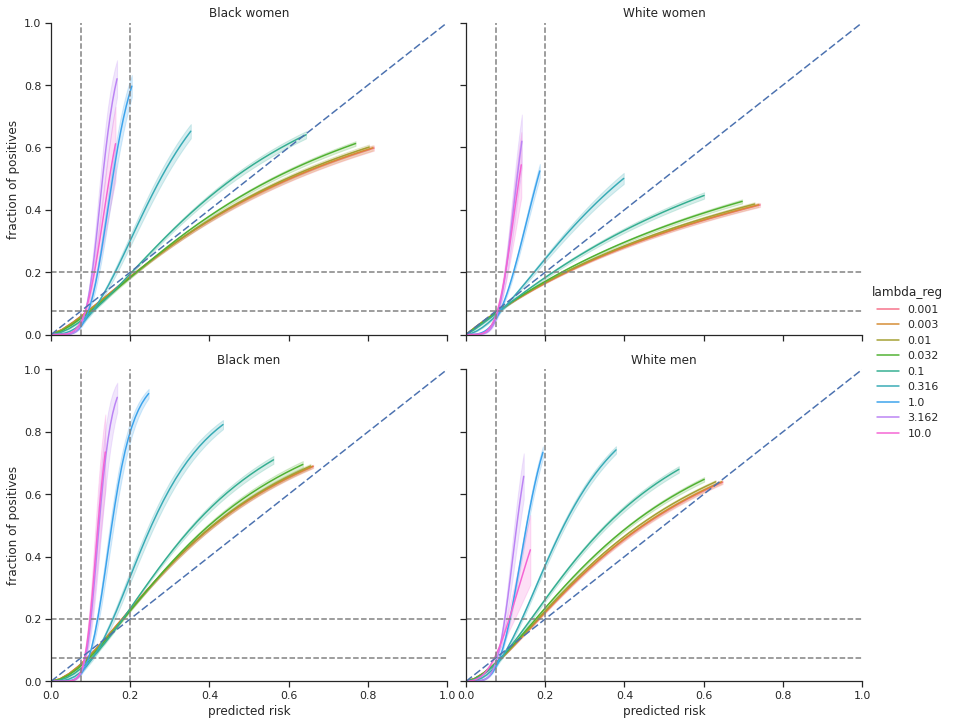

In [15]:
plot(calibrations_df_logx, 
     #output_path = os.path.join(experiment_plot_path, 'calibration_logreg_logx.png')
    )

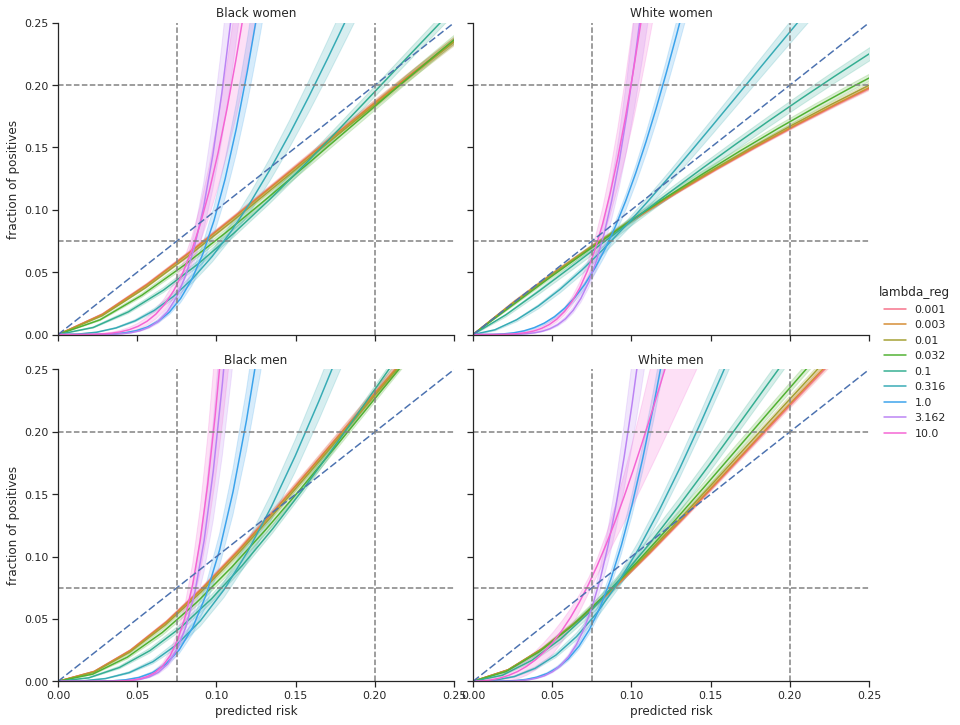

In [16]:
plot(calibrations_df_logx, 
     zoom=True,
     #output_path = os.path.join(experiment_plot_path, 'calibration_logreg_logx_zoom.png')
    )

In [10]:

#     transform='log'
#     calib_dfs = []
#     fits=[]
#     for config_id in range(num_configs):
#         for group in range(1,5):
#             preds_test_grp = preds.query("(phase=='test') \
#                     & (config_id==@config_id) \
#                     & (group==@group)")
#             for fold_id in range(1,11):
#                 preds_test = preds_test_grp.query("fold_id==@fold_id")
#                 lambda_reg = preds_test.lambda_reg.unique()[0]
#                 evaluator = CalibrationEvaluator()
#                 kwargs = {'fold_id': fold_id,
#                           'config_id': config_id,
#                           'group': group,
#                           'lambda_reg': str(round(lambda_reg, 3))
#                          }

#                 df, model = evaluator.get_calibration_density_df(preds_test.labels,
#                                                                  preds_test.pred_probs,
#                                                                  preds_test.weights,
#                                                                  transform = transform)
                                
#                 df_synth = pd.DataFrame({"pred_probs": [0.075, 0.2]})   
#                 calib_synth = get_calib_predictions(df_synth, transform, model)
#                 df_synth = df_synth.assign(calibration_density = calib_synth,
#                                            **kwargs)                   
#                 calib_dfs.append(df_synth)
                

#     calibrations_df = (pd
#                        .concat(calib_dfs)
#                        .assign(is_male = lambda x: np.where((x.group == 3) | (x.group == 4), 1, 0),
#                                is_white = lambda x: np.where((x.group == 2) | (x.group == 4), 1, 0)
#                               )
#                       )

In [11]:
df_to_calibrate = preds_test#.assign(pred_probs = lambda x: test_calibs.calibration_density)

calibs_final=[]
for config_id in range(num_configs):
    for group in [1,2,3,4]:
        max_pred_prob = df_to_calibrate.query("(group==@group) & (config_id==@config_id)").pred_probs.values.max()
        for fold_id in range(1,11): 
            for iter in range(10):
                group_df = (df_to_calibrate
                            .query("(group==@group) & (fold_id==@fold_id) & (config_id==@config_id)")
                            .sample(frac=1, replace=True)
                           )
                lambda_reg = group_df.lambda_reg.unique()[0]

                model = get_calib_model(group_df, transform='log')
                thr_calib = (get_calib_probs(model, 
                                             [0.075, 0.2],
                                             'log')
                             .assign(group = group,
                                    lambda_reg = str(round(lambda_reg, 3)))
                            )
                calibs_final.append(thr_calib)
            print(config_id, group, fold_id)
calibs_final = pd.concat(calibs_final)

0 1 1
0 1 2
0 1 3
0 1 4
0 1 5
0 1 6
0 1 7
0 1 8
0 1 9
0 1 10
0 2 1
0 2 2
0 2 3
0 2 4
0 2 5
0 2 6
0 2 7
0 2 8
0 2 9
0 2 10
0 3 1
0 3 2
0 3 3
0 3 4
0 3 5
0 3 6
0 3 7
0 3 8
0 3 9
0 3 10
0 4 1
0 4 2
0 4 3
0 4 4
0 4 5
0 4 6
0 4 7
0 4 8
0 4 9
0 4 10
1 1 1
1 1 2
1 1 3
1 1 4
1 1 5
1 1 6
1 1 7
1 1 8
1 1 9
1 1 10
1 2 1
1 2 2
1 2 3
1 2 4
1 2 5
1 2 6
1 2 7
1 2 8
1 2 9
1 2 10
1 3 1
1 3 2
1 3 3
1 3 4
1 3 5
1 3 6
1 3 7
1 3 8
1 3 9
1 3 10
1 4 1
1 4 2
1 4 3
1 4 4
1 4 5
1 4 6
1 4 7
1 4 8
1 4 9
1 4 10
2 1 1
2 1 2
2 1 3
2 1 4
2 1 5
2 1 6
2 1 7
2 1 8
2 1 9
2 1 10
2 2 1
2 2 2
2 2 3
2 2 4
2 2 5
2 2 6
2 2 7
2 2 8
2 2 9
2 2 10
2 3 1
2 3 2
2 3 3
2 3 4
2 3 5
2 3 6
2 3 7
2 3 8
2 3 9
2 3 10
2 4 1
2 4 2
2 4 3
2 4 4
2 4 5
2 4 6
2 4 7
2 4 8
2 4 9
2 4 10
3 1 1
3 1 2
3 1 3
3 1 4
3 1 5
3 1 6
3 1 7
3 1 8
3 1 9
3 1 10
3 2 1
3 2 2
3 2 3
3 2 4
3 2 5
3 2 6
3 2 7
3 2 8
3 2 9
3 2 10
3 3 1
3 3 2
3 3 3
3 3 4
3 3 5
3 3 6
3 3 7
3 3 8
3 3 9
3 3 10
3 4 1
3 4 2
3 4 3
3 4 4
3 4 5
3 4 6
3 4 7
3 4 8
3 4 9
3 4 10
4 1 1
4 1 2
4 1 3
4 1 4


In [12]:
a = calibs_final.assign(group = lambda x: x.group.map(grp_label_dict))

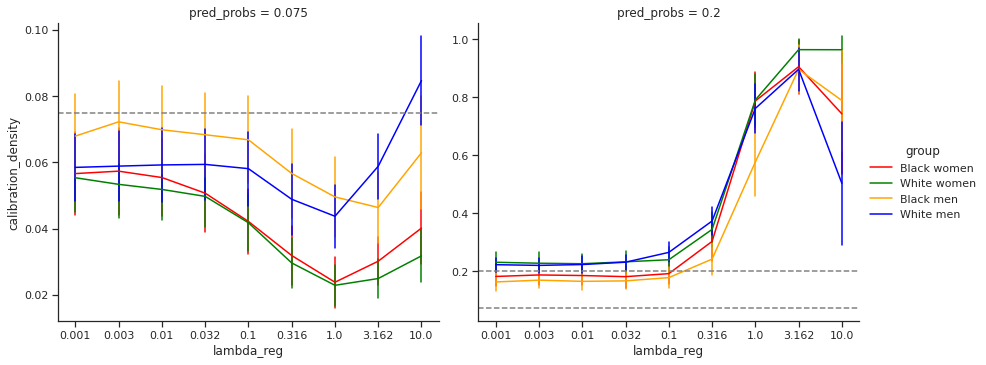

In [18]:
    output_path = os.path.join(experiment_plot_path, 'real_thresholds.png')
    g = sns.relplot(data = a,
                    x = 'lambda_reg',
                    y = 'calibration_density',
#                     row = 'group',
                     col = 'pred_probs',
#                     kind = 'line',
                   hue = 'group',
                    facet_kws = {'sharey': False, 'sharex': False},# 'margin_titles': True},
                    legend = True,
                    ci='sd',
                    kind="line",
                    err_style='bars',
                    aspect = 1.2)
    axes = g.axes.flatten()
    axes[0].axhline(y = 0.075, linestyle = '--', color = 'grey')

    axes[1].axhline(y = 0.075, linestyle = '--', color = 'grey')
    axes[1].axhline(y = 0.2,   linestyle = '--', color = 'grey')
        
    if output_path is not None:
        g.savefig(output_path)